In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path("../..")

In [3]:
mcn_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_MCN.csv")
prd_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRD.csv")
pro_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRO.csv")
ihr_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_IHR.csv")

In [4]:
run_schedules = {
    "mcnary": {'spring': ['04-01', '06-08'], 'summer': ['06-09', '08-08'], 'fall': ['08-09', '10-31']},
    "priest_rapids": {'spring': ['04-15', '06-13'], 'summer': ['06-14', '08-13'], 'fall': ['08-14', '11-15']},
    "prosser": {'spring': ['03-01', '08-15'], 'fall': ['08-16', '12-15']},
    "ice_harbor": {'spring': ['04-01', '06-11'], 'summer': ['06-12', '08-11'], 'fall': ['08-12', '12-15']}
}

In [5]:
# allocate run schedules to each fish data frame
def allocate_runs(df, run_schedule):
    df_copy = df.copy()
    df_copy['year'] = df_copy['date'].dt.year
    for run, dates in run_schedule.items():
        for year in df_copy["year"].unique():
            start_date = pd.Timestamp(f"{year}-{dates[0]}")
            end_date = pd.Timestamp(f"{year}-{dates[1]}")
            df_copy.loc[
                (df_copy["date"] >= start_date) & (df_copy["date"] <= end_date), "run"
            ] = run
        df_copy = pd.concat([df_copy, pd.DataFrame(
            {
                "run": run,
                "year": df_copy["year"].unique(),
            }
        )])
    return df_copy

In [6]:
def post_process(df, name):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df['doy'] = df['date'].dt.dayofyear

    df = allocate_runs(df, run_schedules[name])
    
    return df

In [7]:
mcn_fish_df = post_process(mcn_fish_df, "mcnary")
prd_fish_df = post_process(prd_fish_df, "priest_rapids")
pro_fish_df = post_process(pro_fish_df, "prosser")
ihr_fish_df = post_process(ihr_fish_df, "ice_harbor")

In [8]:
def plot_stacked_run_counts(df, ax, title, species="chinook"):

    bottom = np.zeros(len(df["year"].unique()))
    for run, group in df.fillna(0).groupby("run"):
        if run != 0:
            year_group = group.groupby("year")[species].sum().reset_index()
            # fig, ax = plt.subplots()
            p = ax.bar(
                year_group["year"], year_group[species], label=run, bottom=bottom
            )
            # print(group.groupby("year")[species].sum().reset_index())
            bottom += group.groupby("year")[species].sum()
    ax.set_title(title)
    ax.legend()

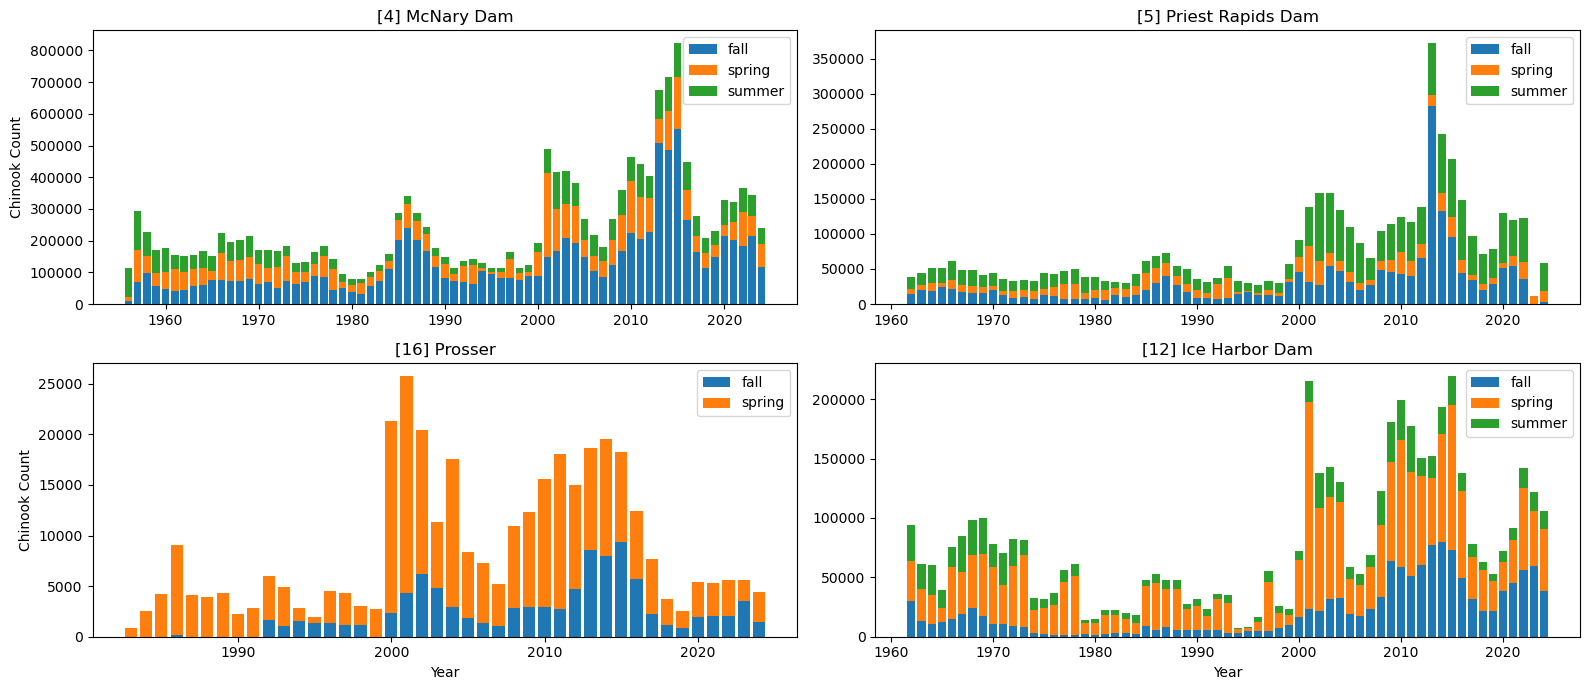

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 7))
plot_stacked_run_counts(mcn_fish_df, axs[0, 0], "[4] McNary Dam")
plot_stacked_run_counts(prd_fish_df, axs[0, 1], "[5] Priest Rapids Dam")
plot_stacked_run_counts(pro_fish_df, axs[1, 0], "[16] Prosser")
plot_stacked_run_counts(ihr_fish_df, axs[1, 1], "[12] Ice Harbor Dam")

axs[0, 0].set_ylabel("Chinook Count")
axs[1, 0].set_ylabel("Chinook Count")

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")

fig.tight_layout()

# Chinook population in the Hanford Reach

Using the concept of control volume to assess the adult migration and population in the Hanford reach.  
Adult Chinook entering the reach:  
* McNary Dam: $Ch_{4}$

Adult Chinook exiting the reach:  
* Priest Rapids Dam: $Ch_{5}$
* Ice Harbor Dam: $Ch_{12}$
* Proser: $Ch_{16}$

Adult Chinook population in the reach:
* Hanford Reach: $Ch_{hr}$

Change in adult chinook population in the reach ($\Delta Ch_{hr}$):  
* $\Delta Ch_{hr} = Ch_{4} - Ch_{5} - Ch_{12} - Ch_{16}$

In [10]:
mcnary_chinook_df = mcn_fish_df[['date', 'year', 'month', 'day', 'chinook', 'run', 'avg_temp(C)']].copy()
priest_rapids_chinook_df = prd_fish_df[['date', 'year', 'month', 'day', 'chinook', 'run', 'avg_temp(C)']].copy()
prosser_chinook_df = pro_fish_df[['date', 'year', 'month', 'day', 'chinook', 'run']].copy()
ice_harbor_chinook_df = ihr_fish_df[['date', 'year', 'month', 'day', 'chinook', 'run', 'avg_temp(C)']].copy()

In [11]:
yearly_spring_chinook = mcnary_chinook_df[(mcnary_chinook_df['run'] == 'spring')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'mcnary'}).merge(
    priest_rapids_chinook_df[(priest_rapids_chinook_df['run'] == 'spring')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'priest_rapids'}),
    on='year', how='outer'
).merge(
    prosser_chinook_df[(prosser_chinook_df['run'] == 'spring')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'prosser'}),
    on='year', how='outer'
).merge(
    ice_harbor_chinook_df[(ice_harbor_chinook_df['run'] == 'spring')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'ice_harbor'}),
    on='year', how='outer'
)



yearly_spring_chinook = yearly_spring_chinook[(yearly_spring_chinook['year'] >= 2000) & (yearly_spring_chinook['year'] <= 2022)]
yearly_spring_chinook['delta'] = yearly_spring_chinook['mcnary'] - yearly_spring_chinook['priest_rapids'] - yearly_spring_chinook['prosser'] - yearly_spring_chinook['ice_harbor']
yearly_spring_chinook['percent_delta'] = yearly_spring_chinook['delta'] / yearly_spring_chinook['mcnary']

In [12]:
yearly_summer_chinook = mcnary_chinook_df[(mcnary_chinook_df['run'] == 'summer')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'mcnary'}).merge(
    priest_rapids_chinook_df[(priest_rapids_chinook_df['run'] == 'summer')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'priest_rapids'}),
    on='year', how='outer'
).merge(
    ice_harbor_chinook_df[(ice_harbor_chinook_df['run'] == 'summer')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'ice_harbor'}),
    on='year', how='outer'
)

yearly_summer_chinook = yearly_summer_chinook[(yearly_summer_chinook['year'] >= 2000) & (yearly_summer_chinook['year'] <= 2022)]
yearly_summer_chinook['delta'] = yearly_summer_chinook['mcnary'] - yearly_summer_chinook['priest_rapids'] - yearly_summer_chinook['ice_harbor']
yearly_summer_chinook['percent_delta'] = yearly_summer_chinook['delta'] / yearly_summer_chinook['mcnary']

In [13]:
yearly_fall_chinook = mcnary_chinook_df[(mcnary_chinook_df['run'] == 'fall')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'mcnary'}).merge(
    priest_rapids_chinook_df[(priest_rapids_chinook_df['run'] == 'fall')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'priest_rapids'}),
    on='year', how='outer'
).merge(
    prosser_chinook_df[(prosser_chinook_df['run'] == 'fall')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'prosser'}),
    on='year', how='outer'
).merge(
    ice_harbor_chinook_df[(ice_harbor_chinook_df['run'] == 'fall')].groupby('year')['chinook'].sum().reset_index().rename(columns={'chinook': 'ice_harbor'}),
    on='year', how='outer'
)

yearly_fall_chinook = yearly_fall_chinook[(yearly_fall_chinook['year'] >= 2000) & (yearly_fall_chinook['year'] <= 2022)]
yearly_fall_chinook['delta'] = yearly_fall_chinook['mcnary'] - yearly_fall_chinook['priest_rapids'] - yearly_fall_chinook['prosser'] - yearly_fall_chinook['ice_harbor']
yearly_fall_chinook['percent_delta'] = yearly_fall_chinook['delta'] / yearly_fall_chinook['mcnary']

In [14]:
yearly_fall_chinook

,year,mcnary,priest_rapids,prosser,ice_harbor,delta,percent_delta
44,2000,87891.0,45223.0,2329.0,16349.0,23990.0,0.272952
45,2001,146898.0,30757.0,4287.0,23686.0,88168.0,0.600199
46,2002,167114.0,27366.0,6185.0,21327.0,112236.0,0.671613
47,2003,208982.0,54453.0,4848.0,31664.0,118017.0,0.564723
48,2004,193140.0,47406.0,2932.0,32264.0,110538.0,0.572321
49,2005,147189.0,31641.0,1876.0,19238.0,94434.0,0.641583
50,2006,102863.0,20678.0,1399.0,17107.0,63679.0,0.619066
51,2007,85262.0,27033.0,1052.0,23151.0,34026.0,0.399076
52,2008,121792.0,48586.0,2863.0,33451.0,36892.0,0.302910
53,2009,166822.0,46089.0,2976.0,63435.0,54322.0,0.325629


In [15]:
hanford_chinook_df = mcnary_chinook_df[(mcnary_chinook_df['run'] == 'fall')][['date', 'chinook']].rename(columns={'chinook': 'mcnary'}).merge(
    priest_rapids_chinook_df[(priest_rapids_chinook_df['run'] == 'fall')][['date', 'chinook']].rename(columns={'chinook': 'priest_rapids'}),
    on='date', how='outer'
).merge(
    prosser_chinook_df[(prosser_chinook_df['run'] == 'fall')][['date', 'chinook']].rename(columns={'chinook': 'prosser'}),
    on='date', how='outer'
).merge(
    ice_harbor_chinook_df[(ice_harbor_chinook_df['run'] == 'fall')][['date', 'chinook']].rename(columns={'chinook': 'ice_harbor'}),
    on='date', how='outer'
).copy()
hanford_chinook_df['year'] = hanford_chinook_df['date'].dt.year
hanford_chinook_df[['mcnary', 'priest_rapids', 'prosser', 'ice_harbor']] =hanford_chinook_df[['mcnary', 'priest_rapids', 'prosser', 'ice_harbor']].copy().fillna(0)
hanford_chinook_df['delta'] = hanford_chinook_df['mcnary'] - hanford_chinook_df['priest_rapids'] - hanford_chinook_df['prosser'] - hanford_chinook_df['ice_harbor']
hanford_chinook_df.dropna(subset=['year'], inplace=True)

In [16]:
years = hanford_chinook_df['year'].unique()
# sort out the years
years = np.sort(years)
years

array([1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023., 2024.])

In [17]:
_hanford_chinook_df = hanford_chinook_df.resample('W', on='date').sum().reset_index()
_hanford_chinook_df

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta
0,1956-08-12,1267.0,0.0,0.0,0.0,7824.0,1267.0
1,1956-08-19,1533.0,0.0,0.0,0.0,13692.0,1533.0
2,1956-08-26,734.0,0.0,0.0,0.0,13692.0,734.0
3,1956-09-02,460.0,0.0,0.0,0.0,13692.0,460.0
4,1956-09-09,1114.0,0.0,0.0,0.0,13692.0,1114.0
...,...,...,...,...,...,...,...
3550,2024-08-25,8960.0,779.0,214.0,5472.0,14168.0,2495.0
3551,2024-09-01,17815.0,1180.0,567.0,8518.0,14168.0,7550.0
3552,2024-09-08,31716.0,0.0,166.0,11488.0,14168.0,20062.0
3553,2024-09-15,37770.0,0.0,127.0,8088.0,14168.0,29555.0


In [18]:
thorr_df = pd.read_csv(proj_dir / "data/thorr/thorr_temp.csv")
thorr_df['date'] = pd.to_datetime(thorr_df['Date'])
columbia_df = thorr_df[thorr_df['RiverID'] == 9].copy()
snake_df = thorr_df[thorr_df['RiverID'] == 45].copy()
yakima_df = thorr_df[thorr_df['RiverID'] == 58].copy()
# thorr_df = thorr_df[thorr_df['RiverID'] == 9].copy()

In [19]:
# group columbia by reach
grouped_columbia = columbia_df.groupby('RKm')

_merged_columbia = pd.DataFrame(columns=['date'])
for group in grouped_columbia:
    resampled = group[1].resample('W', on='date').mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={'EstTempC': resampled['RKm'].iloc[0]}, inplace=True)
    _merged_columbia = pd.merge(_merged_columbia, resampled[['date', resampled['RKm'].iloc[0]]], on='date', how='outer')

_merged_columbia['date'] = pd.to_datetime(_merged_columbia['date'])

#make date the index
_merged_columbia.set_index('date', inplace=True)
# sort by date
_merged_columbia.sort_index(inplace=True)

# group snake by reach
grouped_snake = snake_df.groupby('RKm')

_merged_snake = pd.DataFrame(columns=['date'])
for group in grouped_snake:
    resampled = group[1].resample('W', on='date').mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={'EstTempC': resampled['RKm'].iloc[0]}, inplace=True)
    _merged_snake = pd.merge(_merged_snake, resampled[['date', resampled['RKm'].iloc[0]]], on='date', how='outer')

_merged_snake['date'] = pd.to_datetime(_merged_snake['date'])

#make date the index
_merged_snake.set_index('date', inplace=True)
# sort by date
_merged_snake.sort_index(inplace=True)

# group yakima by reach
grouped_yakima = yakima_df.groupby('RKm')

_merged_yakima = pd.DataFrame(columns=['date'])
for group in grouped_yakima:
    resampled = group[1].resample('W', on='date').mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={'EstTempC': resampled['RKm'].iloc[0]}, inplace=True)
    _merged_yakima = pd.merge(_merged_yakima, resampled[['date', resampled['RKm'].iloc[0]]], on='date', how='outer')

_merged_yakima['date'] = pd.to_datetime(_merged_yakima['date'])

#make date the index
_merged_yakima.set_index('date', inplace=True)
# sort by date
_merged_yakima.sort_index(inplace=True)

In [20]:
_hanford_temp_df = _merged_columbia[range(460, 630, 10)].reset_index()
_hanford_temp_df['mean_temp'] = _hanford_temp_df.drop(columns=['date']).mean(axis=1)
_hanford_chinook_df = _hanford_chinook_df.merge(_hanford_temp_df, on='date', how='left')
_hanford_chinook_df = allocate_runs(_hanford_chinook_df, run_schedules["mcnary"])

In [21]:
_up_priest_rapids = _merged_columbia[range(640, 670, 10)].reset_index()
_up_priest_rapids['mean_temp'] = _up_priest_rapids.drop(columns=['date']).mean(axis=1)
_up_priest_rapids = allocate_runs(_up_priest_rapids, run_schedules["mcnary"])
_up_priest_rapids.dropna(subset=['mean_temp',]).to_csv("up_priest_rapids.csv", index=False)

In [24]:
combined_han_pri = _hanford_chinook_df.merge(_up_priest_rapids, on='date', how='left')


In [27]:
combined_han_pri['temp_gradient'] = combined_han_pri['mean_temp_x'] - combined_han_pri['mean_temp_y']

In [31]:
combined_han_pri = combined_han_pri.dropna(subset=['temp_gradient']).copy()
combined_han_pri['date'] = pd.to_datetime(combined_han_pri['date'])



In [33]:
combined_han_pri.to_csv('combined_han_pri.csv')

In [37]:
combined_han_pri[['mean_temp_x', 'mean_temp_y', 'temp_gradient']]

,mean_temp_x,mean_temp_y,temp_gradient
1371,11.308000,11.160000,0.148000
1376,6.260000,5.870000,0.390000
1409,20.777059,19.710000,1.067059
1446,8.575000,8.106667,0.468333
1447,10.332500,9.533333,0.799167
...,...,...,...
3548,21.388750,20.963333,0.425417
3549,20.957812,21.066667,-0.108854
3550,21.052059,20.858333,0.193725
3551,20.598235,20.295000,0.303235


In [22]:
_hanford_chinook_df

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta,460.0,470.0,480.0,...,550.0,560.0,570.0,580.0,590.0,600.0,610.0,620.0,mean_temp,run
0,1956-08-12,1267.0,0.0,0.0,0.0,1956,1267.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
1,1956-08-19,1533.0,0.0,0.0,0.0,1956,1533.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
2,1956-08-26,734.0,0.0,0.0,0.0,1956,734.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
3,1956-09-02,460.0,0.0,0.0,0.0,1956,460.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
4,1956-09-09,1114.0,0.0,0.0,0.0,1956,1114.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,NaT,NaN,NaN,NaN,NaN,2020,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
65,NaT,NaN,NaN,NaN,NaN,2021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
66,NaT,NaN,NaN,NaN,NaN,2022,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall
67,NaT,NaN,NaN,NaN,NaN,2023,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall


Text(0, 0.5, 'Change in Chinook Population')

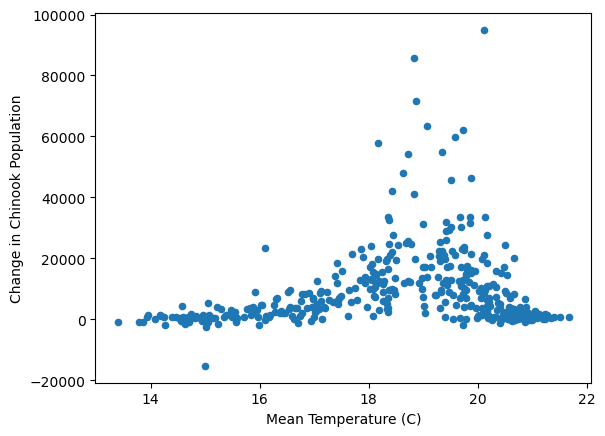

In [23]:
fig, ax = plt.subplots()
_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot.scatter(
    x="mean_temp",
    y="delta",
    ax=ax,
    # c='year', 
    # cmap='viridis'
)
ax.set_xlabel("Mean Temperature (C)")
ax.set_ylabel("Change in Chinook Population")

In [24]:
_hanford_chinook_df.to_csv("hanford_chinook_mass_bal.csv", index=False)

In [38]:
_hanford_chinook_df.dropna(subset=['mean_temp', 'delta']).to_csv("hanford_chinook_mass_bal_no_na.csv", index=False)

In [39]:
_hanford_chinook_df['percent_delta'] = _hanford_chinook_df['delta'] / _hanford_chinook_df['mcnary']

Text(0, 0.5, 'Change in Chinook Population')

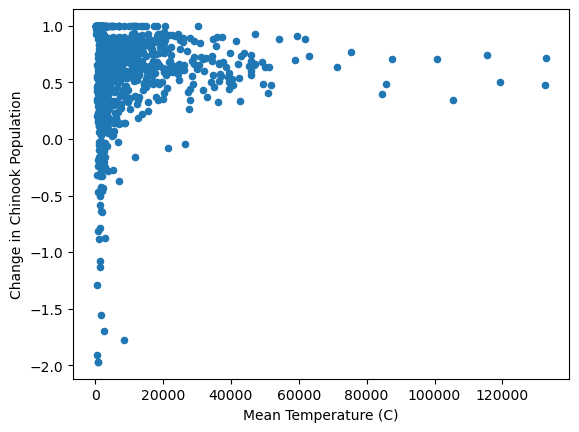

In [46]:
fig, ax = plt.subplots()
_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot.scatter(
    x="mcnary",
    y="percent_delta",
    ax=ax,
    # c='year', 
    # cmap='viridis'
)
ax.set_xlabel("Mean Temperature (C)")
ax.set_ylabel("Change in Chinook Population")
# 1-1 line
# x = np.linspace(0, 1e6, 100)
# ax.plot(x, x, color='red')